In [18]:
import seaborn as sns
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from scipy import sparse
import nltk as nltk
import cv2
import imageio
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.draw.dispersion import dispersion_plot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
#                         category=DeprecationWarning)


pd.set_option('display.max_rows', None)
df = pd.read_json('C:/Users/ins/Desktop/459FinalProject/train.json')
df_test =  pd.read_json('C:/Users/ins/Desktop/459FinalProject/test.json')

listing_id = df_test['listing_id']
#df = pd.read_json('./train.json')
#df_test = pd.read_json('./test.json')

In [19]:
interest_level_map = {'medium':1, 'low':0 , 'high':2}
df['interest_level_num'] = df['interest_level'].apply(lambda x: interest_level_map[x])
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["price_per_bedroom"] =df["price"]/df["bedrooms"]
df['photo_word'] = df['num_photos'] * df['num_words']
df['price_per_feature'] = df['price'] / df['num_features']
df['price_per_feature'] = df['price_per_feature'].replace(np.inf, 0)
df["price_per_bedroom"] = df['price_per_bedroom'].replace(np.inf, 0)
df['price_per_feature'] = df['price_per_feature'].replace(np.NaN, 0)
df["price_per_bedroom"] = df['price_per_bedroom'].replace(np.NaN, 0)
soho_north = 40.7233
soho_west = 74.0030
df['soho_longitude'] = abs(df['latitude'] - soho_north)
df['soho_latitude'] = abs(df['longitude'] + soho_west)

pd.set_option('display.max_columns', None)
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,interest_level_num,num_photos,num_features,num_words,price_per_bedroom,photo_word,price_per_feature,soho_longitude,soho_latitude
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,1,12,7,77,2400.0,924,342.857143,0.0125,0.0491
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,0,6,6,131,1900.0,786,633.333333,0.0280,0.0308
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,1,6,6,119,1747.5,714,582.500000,0.0342,0.0405


In [20]:
df_price = df['price']  
IQR = df_price.quantile(0.75)-df_price.quantile(0.25)
upper = df_price.quantile(0.75)+IQR*1.5
lower = df_price.quantile(0.25)-IQR*1.5 

df1 = df[(df['price'] <upper) & (df['price'] >lower)]

df_lat = df1['latitude']

IQR = df_lat.quantile(0.75)-df_lat.quantile(0.25)
upper = df_lat.quantile(0.75)+IQR*1.5
lower = df_lat.quantile(0.25)-IQR*1.5
 
df2 = df1[(df1['latitude']<upper) & (df1['latitude']>lower)]

df_long = df2['longitude']
 
IQR = df_long.quantile(0.75)-df_long.quantile(0.25)
upper = df_long.quantile(0.75)+IQR*1.5
lower = df_long.quantile(0.25)-IQR*1.5 
df3 = df2[(df2['longitude'] >lower) & (df2['longitude']<upper)]

df_bedrooms = df3['bedrooms']
 
IQR = df_bedrooms.quantile(0.75)-df_bedrooms.quantile(0.25)
upper = df_bedrooms.quantile(0.75)+IQR*1.5
lower = max(df_bedrooms.quantile(0.25)-IQR*1.5, 0)
 
df4 = df3[(df3['bedrooms'] >= lower) & (df3['bedrooms'] <= upper)]

df_bathrooms = df4['bathrooms']
 
IQR = df_bathrooms.quantile(0.75)-df_bathrooms.quantile(0.25)

upper = math.ceil(df_bathrooms.quantile(0.75)+IQR*1.5)
lower = max(df_bathrooms.quantile(0.25)-IQR*1.5, 0)
average = sum(df_bathrooms) / len(df_bathrooms)

df5 = df4[(df4['bathrooms'] >= lower) & (df4['bathrooms'] <= upper)]

In [21]:
y = df5["interest_level"] 
features_to_use=['interest_level_num',"bedrooms", 'manager_id', "soho_latitude", "soho_longitude","latitude", "longitude", "price","num_photos", "num_features", "num_words","photo_word",'price_per_feature','price_per_bedroom']
# features_to_use=['interest_level_num','manager_id', "bedrooms", "latitude", "longitude", "price"]

df6 = df5[features_to_use]


In [22]:
temp = pd.concat([df6.manager_id,pd.get_dummies(y)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_interest_percent','low_interest_percent', 'medium_interest_percent']
temp['count'] = df6.groupby('manager_id').count().iloc[:,1]
temp['manager_skill'] =  temp['high_interest_percent'] +  0.5 * temp['medium_interest_percent'] - temp['low_interest_percent']

df6 = df6.merge(temp['manager_skill'], how='left', left_on='manager_id', right_on='manager_id')
X = df6.drop(columns=['manager_id'], axis=1) 
X.head()

,interest_level_num,bedrooms,soho_latitude,soho_longitude,latitude,longitude,price,num_photos,num_features,num_words,photo_word,price_per_feature,price_per_bedroom,manager_skill
0,1,1,0.0491,0.0125,40.7108,-73.9539,2400,12,7,77,924,342.857143,2400.0,-0.400000
1,0,2,0.0308,0.0280,40.7513,-73.9722,3800,6,6,131,786,633.333333,1900.0,-0.022727
2,1,2,0.0405,0.0342,40.7575,-73.9625,3495,6,6,119,714,582.500000,1747.5,-0.584337
3,0,0,0.0287,0.0206,40.7439,-73.9743,2795,4,4,41,164,698.750000,0.0,-0.826923
4,2,0,0.0563,0.0536,40.7769,-73.9467,1945,5,5,62,310,389.000000,0.0,-0.314286


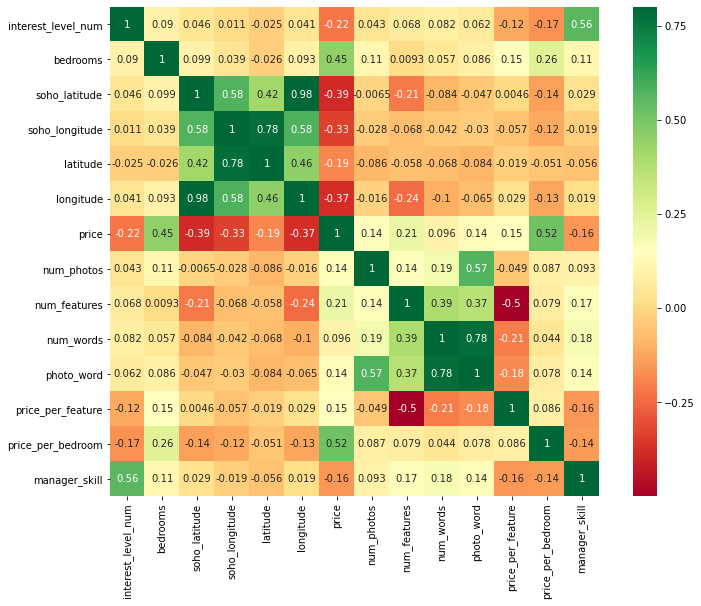

In [23]:
corrmat = X.corr()        # Finds correlation between all the columns
f, ax = plt.subplots(figsize=(12, 9))             # Increases the figure size to (12, 9)
sns.heatmap(corrmat, vmax = 0.8, square=True,annot=True,cmap="RdYlGn");

In [28]:
print("Features affects to interest level : \n")
related_cols = corrmat.nlargest(20, 'interest_level_num')
print(related_cols['interest_level_num'])

Features affects to interest level : 

interest_level_num    1.000000
manager_skill         0.559728
bedrooms              0.089819
num_words             0.082064
num_features          0.068078
photo_word            0.062322
soho_latitude         0.046219
num_photos            0.043285
longitude             0.041355
soho_longitude        0.011306
latitude             -0.024592
price_per_feature    -0.115025
price_per_bedroom    -0.165253
price                -0.220212
Name: interest_level_num, dtype: float64


## Test preprocess

In [6]:
df_test = df_test.merge(temp['manager_skill'], how='left', left_on='manager_id', right_on='manager_id')
df_test["manager_skill"] = df_test['manager_skill'].replace(np.NaN , 0)
df_test["num_photos"] = df_test["photos"].apply(len)
df_test["num_features"] = df_test["features"].apply(len)
df_test["num_words"] = df_test["description"].apply(lambda x: len(x.split(" ")))
df_test["price_per_bedroom"] =df_test["price"]/df_test["bedrooms"]
df_test['photo_word'] = df_test['num_photos'] * df_test['num_words']
df_test['price_per_feature'] = df_test['price'] / df_test['num_features']
df_test['price_per_feature'] = df_test['price_per_feature'].replace(np.inf , 0)
df_test["price_per_bedroom"] = df_test['price_per_bedroom'].replace(np.inf , 0)
df_test['price_per_feature'] = df_test['price_per_feature'].replace(np.NaN , 0)
df_test["price_per_bedroom"] = df_test['price_per_bedroom'].replace(np.NaN , 0)

pd.set_option('display.max_columns', None)

df_testSet = df_test.drop(columns=['listing_id','building_id','features','description','photos', 'manager_id','created','display_address','street_address'])
,'description', 'building_id', 'manager_id','created', 'display_address', 'street_address', 'photos'], axis=1) 




columnsTitles = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_words', 'photo_word', 'price_per_feature', 'price_per_bedroom', 'manager_skill']
df_testSet = df_testSet.reindex(columns=columnsTitles)


In [7]:
print(df_testSet[df_testSet['manager_skill'] == 0].count())
df_testSet.head(100)

bathrooms            3088
bedrooms             3088
latitude             3088
longitude            3088
price                3088
num_photos           3088
num_features         3088
num_words            3088
photo_word           3088
price_per_feature    3088
price_per_bedroom    3088
manager_skill        3088
dtype: int64


,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_words,photo_word,price_per_feature,price_per_bedroom,manager_skill
0,1.0,1,40.7185,-73.9865,2950,8,6,78,624,491.666667,2950.000000,-0.083333
1,1.0,2,40.7278,-74.0000,2850,3,3,35,105,950.000000,1425.000000,-1.000000
2,1.0,0,40.7260,-74.0026,2295,1,3,39,39,765.000000,0.000000,-0.482913
3,1.0,2,40.7321,-74.0028,2900,4,3,22,88,966.666667,1450.000000,-0.457031
4,1.0,1,40.7054,-74.0095,3254,6,10,85,510,325.400000,3254.000000,-0.289474
5,2.0,2,40.7610,-73.9983,4990,8,12,134,1072,415.833333,2495.000000,-0.437500
6,3.5,4,40.7358,-73.9877,20000,15,3,9,135,6666.666667,5000.000000,-0.951613
7,1.0,0,40.7814,-73.9507,2150,3,5,90,270,430.000000,0.000000,0.144231
8,2.0,4,40.7216,-73.9927,6500,7,1,1,7,6500.000000,1625.000000,-1.000000
9,1.0,1,40.7553,-73.9953,3365,18,3,9,162,1121.666667,3365.000000,-1.000000


## Classifiers

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
  
# clf = BernoulliNB(alpha=0, fit_prior=False)

clf = KNeighborsClassifier(n_neighbors=100)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X, y, cv=5)

# Predict labels on the test data using the trained classifier.
predictions = clf.predict(X_test)

# Calculate the F1 score by comparing predicted and actual labels.
F1 = f1_score(y_test, predictions, average='weighted')

y_prob = clf.predict_proba(X_test) 
logloss = log_loss(y_test, y_prob)


print(np.mean(scores))
print(F1)
print(logloss)

0.6894194174063032
0.6089744239756475
0.7312682781915207


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
  
# clf = BernoulliNB(alpha=0, fit_prior=False)

clf = KNeighborsClassifier(n_neighbors=200)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X, y, cv=5)

# Predict labels on the test data using the trained classifier.
predictions = clf.predict(X_test)

# Calculate the F1 score by comparing predicted and actual labels.
F1 = f1_score(y_test, predictions, average='weighted')

y_prob = clf.predict_proba(X_test) 
logloss = log_loss(y_test, y_prob)


print(np.mean(scores))
print(F1)
print(logloss)

0.6880732900003894
0.5949710318734112
0.7065762678386297


In [14]:
Xt = df_testSet  
 
high = []
low=[]
medium = []
 
    
for i in range(0,Xt.shape[0]): 
    h = clf.predict_proba(Xt[i:i+1])[0][0]
    l = clf.predict_proba(Xt[i:i+1])[0][1]
    m = clf.predict_proba(Xt[i:i+1])[0][2]

    high.append(h)
    low.append(l)
    medium.append(m)
    

In [15]:
df_test = pd.DataFrame()  
df_test['listing_id'] = listing_id
df_test['high'] = high
df_test['medium'] = medium
df_test['low'] = low

df_test.to_csv(r'KNeighbor_FinalProject.csv', index = False)
df_test.head()


,listing_id,high,medium,low
0,7142618,0.060,0.305,0.635
1,7210040,0.130,0.270,0.600
2,7174566,0.015,0.140,0.845
3,7191391,0.115,0.250,0.635
5,7171695,0.065,0.180,0.755
